In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

#from pandas_profiling import ProfileReportofileReport

import warnings
warnings.filterwarnings('ignore')

In [2]:
from fairlearn.metrics import MetricFrame
from fairlearn.metrics import selection_rate, false_positive_rate,true_positive_rate,count


from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression,Lasso
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score,precision_score,recall_score,roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier

from xgboost import XGBRegressor,XGBClassifier
from catboost import CatBoostClassifier
import shap

from category_encoders.target_encoder import TargetEncoder
from category_encoders.m_estimate import MEstimateEncoder
from category_encoders.cat_boost import CatBoostEncoder
from category_encoders.leave_one_out import LeaveOneOutEncoder

from tqdm.notebook import tqdm
from collections import defaultdict 

In [3]:
#pd.read_csv('propublica_data_for_fairml.csv').head()

In [4]:
df = pd.read_csv("data/compas-scores-raw.csv")

df["Score"] = df["DecileScore"]

# df.loc[df["DecileScore"] > 7, "Score"] = 2
# df.loc[(df["DecileScore"] > 4) & (df["DecileScore"] < 8), "Score"] = 1
# df.loc[df["DecileScore"] < 5, "Score"] = 0

df.loc[df["DecileScore"] > 4, "Score"] = 1
df.loc[df["DecileScore"] <= 4, "Score"] = 0


cols = [
    "Person_ID",
    "AssessmentID",
    "Case_ID",
    "LastName",
    "FirstName",
    "MiddleName",
    "DateOfBirth",
    "ScaleSet_ID",
    "Screening_Date",
    "RecSupervisionLevel",
    "Agency_Text",
    "AssessmentReason",
    "Language",
    "Scale_ID",
    "IsCompleted",
    "IsDeleted",
    "AssessmentType",
    "DecileScore",
]


df = df.drop(columns=cols)

possible_targets = ["RawScore", "ScoreText", "Score"]

X = df.drop(columns=possible_targets)
y = df[["Score"]]

In [5]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.33, random_state=42)

In [6]:
te = CatBoostEncoder(sigma=3)
model = XGBClassifier()
pipe = Pipeline([('encoder', te), ('model', model)])

pipe.fit(X_tr,y_tr)

preds = pipe.predict(X_te)



[22:05:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [20]:
explainer = shap.TreeExplainer(pipe.named_steps["model"])
shap_values = explainer.shap_values(pipe[:-1].transform(X_tr))


In [21]:
shap_values

array([[-0.00191619, -0.0815032 ,  0.08533502, ..., -0.1539359 ,
        -0.85130244, -0.04829725],
       [-0.00408115, -0.14422251,  0.1276895 , ..., -0.17031375,
        -0.85317284, -0.01711777],
       [-0.00324809, -0.07219427,  0.1379215 , ..., -0.15306894,
        -0.87569165, -0.05777721],
       ...,
       [-0.02067016, -0.18434723,  0.03809347, ..., -0.17836294,
         0.08111948, -0.11232583],
       [-0.00360628, -0.14435656,  0.1698388 , ..., -0.16250265,
        -0.833127  , -0.01871572],
       [-0.01711412, -0.18408458,  0.07030366, ..., -0.18461159,
         0.14333007, -0.06147352]], dtype=float32)

In [16]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

In [12]:
shap_values.squeeze()

array([[-0.00191619, -0.0815032 ,  0.08533502, ..., -0.1539359 ,
        -0.85130244, -0.04829725],
       [-0.00408115, -0.14422251,  0.1276895 , ..., -0.17031375,
        -0.85317284, -0.01711777],
       [-0.00324809, -0.07219427,  0.1379215 , ..., -0.15306894,
        -0.87569165, -0.05777721],
       ...,
       [-0.02067016, -0.18434723,  0.03809347, ..., -0.17836294,
         0.08111948, -0.11232583],
       [-0.00360628, -0.14435656,  0.1698388 , ..., -0.16250265,
        -0.833127  , -0.01871572],
       [-0.01711412, -0.18408458,  0.07030366, ..., -0.18461159,
         0.14333007, -0.06147352]], dtype=float32)

In [19]:
shap.plots.bar(shap_values.values)

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [9]:
gm = MetricFrame(
    metrics=accuracy_score,
    y_true=y_te,
    y_pred=preds,
    sensitive_features=X_te["Sex_Code_Text"],
)
print(gm.overall)
print(gm.by_group)

gm = MetricFrame(
    metrics=accuracy_score,
    y_true=y_te,
    y_pred=preds,
    sensitive_features=X_te["Ethnic_Code_Text"],
)

print(gm.by_group)

gm = MetricFrame(
    metrics=accuracy_score,
    y_true=y_te,
    y_pred=preds,
    sensitive_features=X_te["RecSupervisionLevelText"],
)

print(gm.by_group)

0.6805119776881319
Sex_Code_Text
Female    0.735368
Male       0.66531
Name: accuracy_score, dtype: object
Ethnic_Code_Text
African-Am          0.416667
African-American    0.572278
Arabic              0.833333
Asian               0.846847
Caucasian           0.748179
Hispanic            0.793374
Native American     0.671053
Oriental            0.818182
Other               0.841608
Name: accuracy_score, dtype: object
RecSupervisionLevelText
High                                  0.167894
Low                                   0.892282
Medium                                0.413852
Medium with Override Consideration    0.267319
Name: accuracy_score, dtype: object


In [10]:
def fit_predict(modelo, enc, data, target, test):
    pipe = Pipeline([("encoder", enc), ("model", modelo)])
    pipe.fit(data, target)
    return pipe.predict(test)


def auc_group(model, data, y_true, dicc, group: str = ""):
    aux = data.copy()
    aux["target"] = y_true
    cats = aux[group].unique().tolist()
    cats = cats + ["all"]

    if len(dicc) == 0:
        dicc = defaultdict(list, {k: [] for k in cats})

    for cat in cats:
        if cat != "all":
            aux2 = aux[aux[group] == cat]
            preds = model.predict_proba(aux2.drop(columns="target"))[:, 1]
            truth = aux2["target"]
            dicc[cat].append(roc_auc_score(truth, preds))
        else:
            dicc[cat].append(roc_auc_score(y_true, model.predict_proba(data)[:, 1]))

    return dicc

  0%|          | 0/20 [00:00<?, ?it/s]

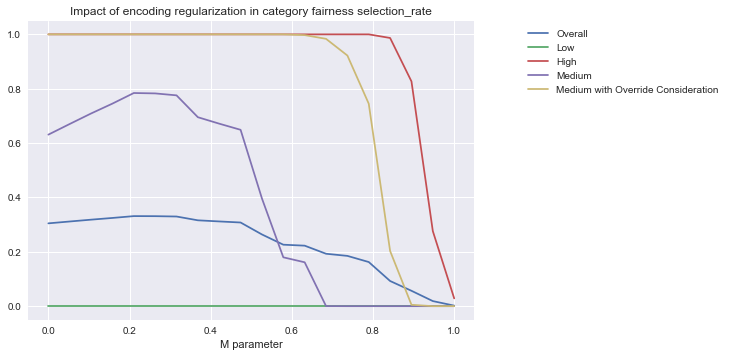

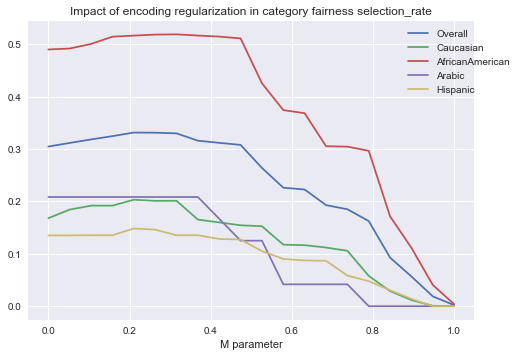

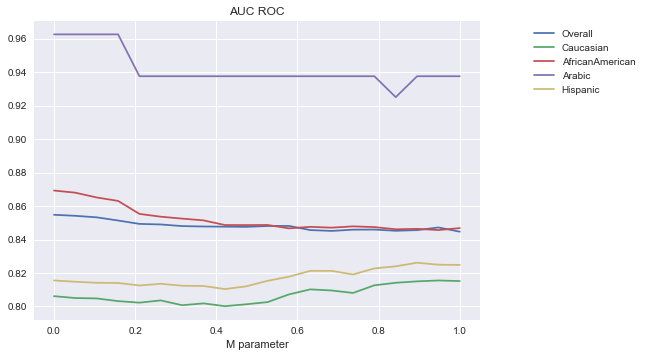

  0%|          | 0/20 [00:00<?, ?it/s]

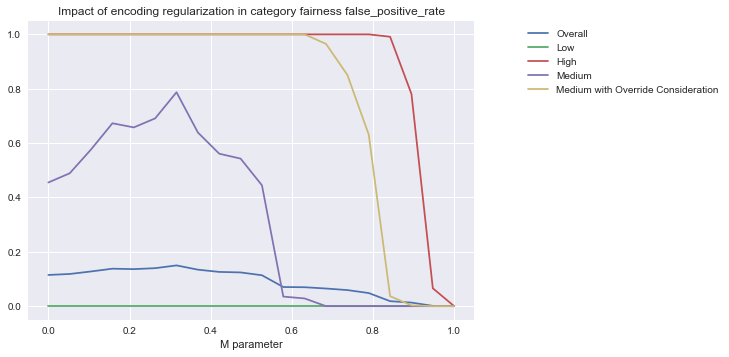

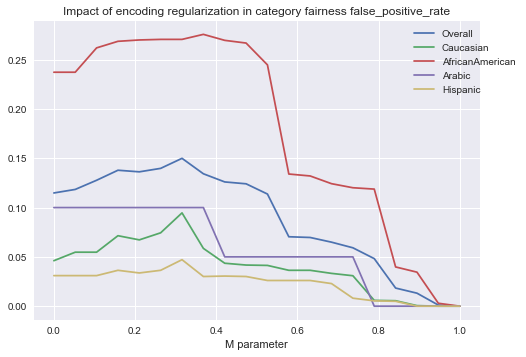

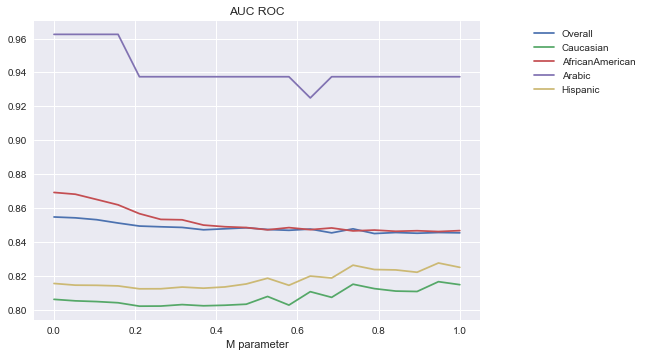

  0%|          | 0/20 [00:00<?, ?it/s]

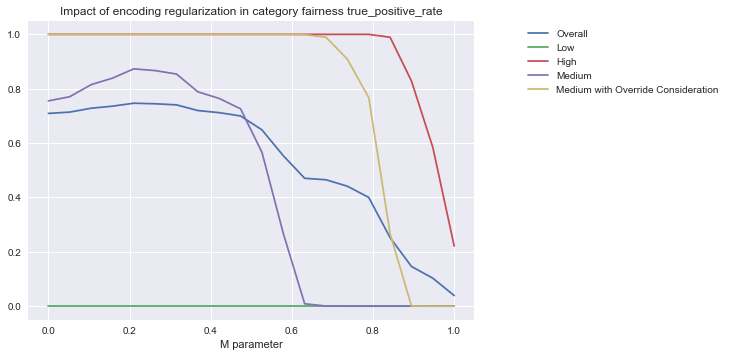

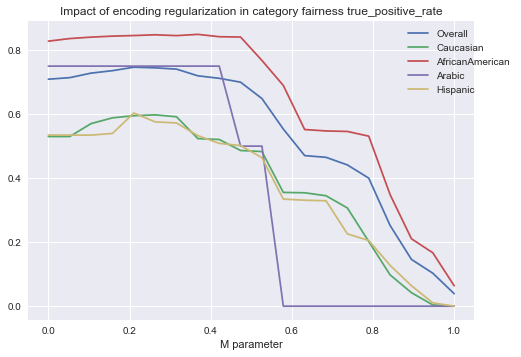

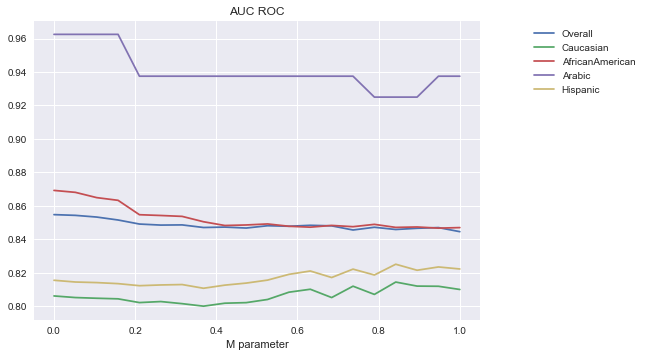

In [11]:
for metrics in [selection_rate, false_positive_rate, true_positive_rate]:
    gms = []
    gms_rec = []
    ms = []
    auc = {}

    #param = [0, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10_000, 20_000]
    param = np.linspace(0,1,20)
    for m in tqdm(param):
        # encoder = MEstimateEncoder(m=m)
        # encoder = TargetEncoder(smoothing=m)
        encoder = LeaveOneOutEncoder(sigma=m)
        model = LogisticRegression()
        #model = GradientBoostingClassifier()

        pipe = Pipeline([("encoder", encoder), ("model", model)])
        pipe.fit(X_tr, y_tr)
        preds = pipe.predict(X_te)

        gm = MetricFrame(
            metrics=metrics,
            y_true=y_te,
            y_pred=preds,
            sensitive_features=X_te["Ethnic_Code_Text"],
        )
        auc = auc_group(
            model=pipe, data=X_te, y_true=y_te, dicc=auc, group="Ethnic_Code_Text"
        )
        gm_rec = MetricFrame(
            metrics=metrics,
            y_true=y_te,
            y_pred=preds,
            sensitive_features=X_te["RecSupervisionLevelText"],
        )

        gms.append(gm)
        gms_rec.append(gm_rec)
        ms.append(m)

    # Impact Score
    plt.figure()
    title = "Impact of encoding regularization in category fairness " + str(
        metrics.__name__
    )
    plt.title(title)
    plt.xlabel("M parameter")
    plt.plot(ms, [gm.overall for gm in gms_rec], label="Overall")
    plt.plot(ms, [gm.by_group["Low"] for gm in gms_rec], label="Low")
    plt.plot(ms, [gm.by_group["High"] for gm in gms_rec], label="High")
    plt.plot(ms, [gm.by_group["Medium"] for gm in gms_rec], label="Medium")
    plt.plot(
        ms,
        [gm.by_group["Medium with Override Consideration"] for gm in gms_rec],
        label="Medium with Override Consideration",
    )

    plt.legend(bbox_to_anchor=(1.1, 1))
    plt.show()

    # Ethnic
    plt.figure()
    title = "Impact of encoding regularization in category fairness " + str(
        metrics.__name__
    )
    plt.title(title)
    plt.xlabel("M parameter")
    plt.plot(ms, [gm.overall for gm in gms], label="Overall")
    plt.plot(ms, [gm.by_group["Caucasian"] for gm in gms], label="Caucasian")
    plt.plot(
        ms, [gm.by_group["African-American"] for gm in gms], label="AfricanAmerican"
    )
    plt.plot(ms, [gm.by_group["Arabic"] for gm in gms], label="Arabic")
    plt.plot(ms, [gm.by_group["Hispanic"] for gm in gms], label="Hispanic")
    # plt.plot(ms,[gm.by_group['Oriental'] for gm in gms],label='Oriental')
    plt.legend(bbox_to_anchor=(1.1, 1))
    plt.show()

    # AUC ROC
    plt.title("AUC ROC")
    plt.xlabel("M parameter")
    plt.plot(ms, auc["all"], label="Overall")
    plt.plot(ms, auc["Caucasian"], label="Caucasian")
    plt.plot(ms, auc["African-American"], label="AfricanAmerican")
    plt.plot(ms, auc["Arabic"], label="Arabic")
    plt.plot(ms, auc["Hispanic"], label="Hispanic")
    plt.legend(bbox_to_anchor=(1.1, 1))
    plt.show()

In [12]:
kk

NameError: name 'kk' is not defined

In [ ]:
X_tr.head()

In [ ]:
d = {}

for i in range(0,2):
    d = auc_group(model=pipe, data=X_tr, y_true=y_tr, dicc=d,group='Sex_Code_Text')

In [ ]:
d

In [ ]:
aa

$\frac{group\_mean * n\_samples + global\_mean * m}{n\_samples + m}$

In [ ]:
X,y
groupby(X['feat_cat'])[y].mean()

In [ ]:
y.global = 0.5

y.spana = 0.2
y.francia = 0.8

In [ ]:
n = 10000
m-regularizador

# Other Data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
data = fetch_openml(data_id=1590, as_frame=True)
X = pd.get_dummies(data.data)
y_true = (data.target == '>50K') * 1
sex = data.data['sex']
sex.value_counts()

In [ ]:
from fairlearn.metrics import MetricFrame
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

In [ ]:
classifier = DecisionTreeClassifier(min_samples_leaf=10, max_depth=4)
classifier.fit(X, y_true)
DecisionTreeClassifier()
y_pred = classifier.predict(X)
gm = MetricFrame(metrics=accuracy_score, y_true=y_true, y_pred=y_pred, sensitive_features=sex)

In [ ]:
data.data['sex']